### Ergodic Fluctuations Between Stochastic Simulation Realizations

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

Cite as: Pyrcz, M.J., 2024, Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy, https://geostatsguy.github.io/GeostatsPyDemos_Book. 

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This chapter is a tutorial for / demonstration of **Ergodic Fluctuations Between Stochastic Simulation Realizations**. 

* this is the fluctuations in the reproduction of input statistics over multiple simulation realizations.

**YouTube Lecture**: check out my lectures:

* [Stochastic Simulation](https://youtu.be/3cLqK3lR56Y?si=3WhHX5QOZrrtlgAI). 
* [Dispersion Variance](https://youtu.be/UI81msM0wXQ?si=Ige9n70STMfC6kwU)

For your convenience here's a summary of salient points.

#### Estimation vs. Simulation

Let's start by comparing spatial estimation and simulation.

Estimation: 

* honors local data 
* locally accurate, primary goal of estimation is 1 estimate! 
* too smooth, appropriate for visualizing trends 
* too smooth, inappropriate for flow simulation 
* one model, no assessment of global uncertainty 

Simulation: 

* honors local data 
* sacrifices local accuracy, reproduces histogram 
* honors spatial variability, appropriate for flow simulation 
* alternative realizations, change random number seed 
* many models (realizations), assessment of global uncertainty

Simulation honors global statistics in expected value over multiple realizations:

* Expect some statistical fluctuation in the input statistics
* These are a function of the ratio of spatial continuity to the size of the model.
* If model is large relative to spatial continuity range then fluctuations should minimal
* If model is small relative to spatial continuity range then fluctuations may be extreme 

In the case of the global mean we can calculate the variance in the means over multiple realizations prior to actually calculating the simulation realizations.

* the variance in the mean over realizations is the dispersion variance of the volume of interest in an infinite domain, to learn more about dispersion variance check out my lecture [Dispersion Variance](https://youtu.be/UI81msM0wXQ?si=tysIrNpwfrMz6te1) and linked demonstrations.

In this workflow we run multiple simulation realizations, calculate the statistics and observe these fluctuations.

#### Load the Required Libraries

The following code loads the required libraries. 

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

GeostatsPy version: 0.0.72


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
import os                                                     # set working directory, run executables
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib import gridspec                               # custom subplots
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
from IPython.utils import io                                  # mute output from simulation

#### Simulation Parameters, Data with Reference Distribution

We need a full reference distribution for the feature of interest, but for unconditional simulated realizations. 
* we accomplish this with a set of data samples outside the range of spatial correlation from the AOI.
* this is used by the sequential Gaussian simulation program to support the distribution backtransformation from Gaussian space.
* while the data will inform the distribution transformation, they are outside the range of spatial continuity and will not locally condition the model

In [3]:
nx = 100; ny = 1; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1 # grid specification
ndmin = 0; ndmax = 20; radius = 2000; skmean = 0; tmin = -99999; tmax = 99999; nreal = 10 # simulation parameters

df = pd.DataFrame(np.vstack([np.full(1000,-9999),np.random.normal(size=1000), # reference distribution outside VOI
                np.random.normal(loc=1000,scale=200,size=1000)]).T, columns= ['X','Y','Lithium'])

df.loc[0,'X'] = 105; df.loc[0,'Y'] = 5.0; df.loc[0,'Lithium'] = 800 # add 3 data in VOI for visualization of conditioning
df.loc[1,'X'] = 505; df.loc[1,'Y'] = 5.0; df.loc[1,'Lithium'] = 1000
df.loc[2,'X'] = 905; df.loc[2,'Y'] = 5.0; df.loc[2,'Lithium'] = 950

df.head()

,X,Y,Lithium
0,105.0,5.000000,800.000000
1,505.0,5.000000,1000.000000
2,905.0,5.000000,950.000000
3,-9999.0,1.365792,548.998595
4,-9999.0,-0.225617,769.742204


#### Make Truth Model

For visualization, simulate a consistent truth model.

* we use the same reference distribution and variogram model for truth and realizations, assuming perfect / no error inference

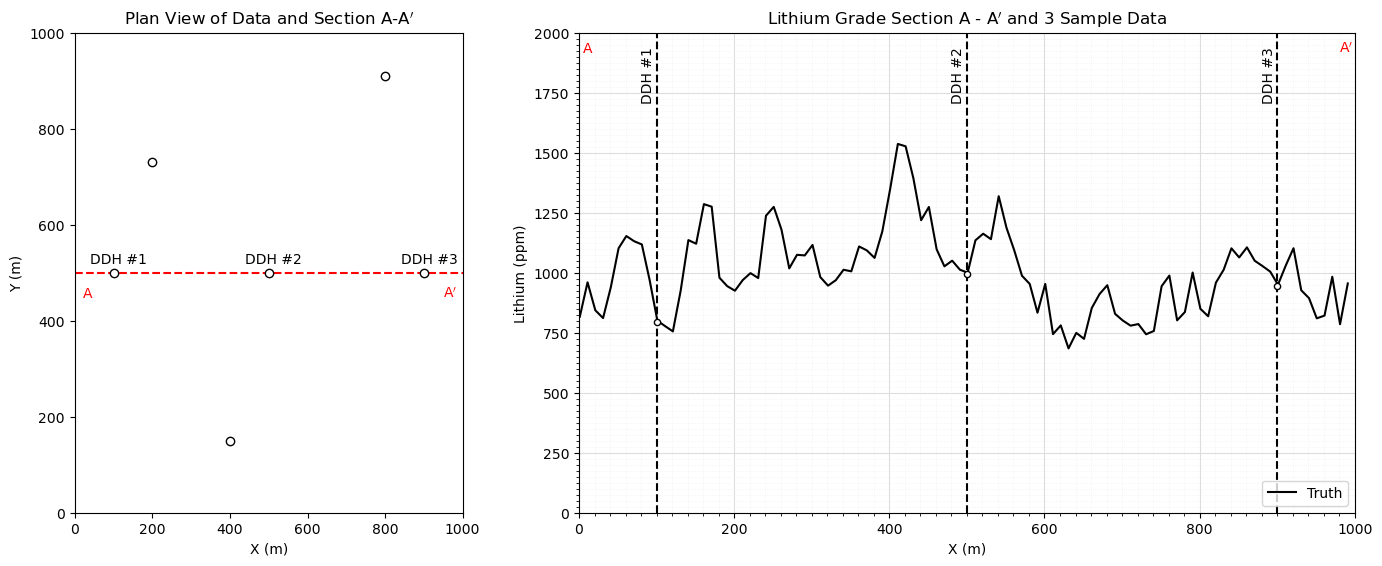

In [4]:
vario_truth = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90.0,hmaj1=100,hmin1=5) # truth variogram

fig = plt.figure()
grid_spec = gridspec.GridSpec(ncols = 2,nrows=1,width_ratios=[1, 2])

ax0 = fig.add_subplot(grid_spec[0])

ax0.scatter([100,500,900,400,200,800],[500,500,500,150,730,910],color='white',edgecolor='black',zorder=10) # data for viz
plt.plot([0,1000],[500,500],ls='--',color='red',zorder=1)
plt.annotate(r'DDH #1',(40,520)); plt.annotate(r'DDH #2',(440,520)) # plot 3 conditioning data 
plt.annotate(r'DDH #3',(840,520)) 
plt.annotate(r'A',(20,450),color='red'); plt.annotate(r'A$^\prime$',(950,450),color='red')  

plt.xlim([0,1000]); plt.ylim([0,1000]); plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Plan View of Data and Section A-A$^\prime$')
ax1 = fig.add_subplot(grid_spec[1])                           # cross section
with io.capture_output() as captured:                         # mute simulation output
    truth = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
        twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=1,
        nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=72067,
        ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,
        ktype=0,colocorr=0.0,sec_map=0,vario=vario_truth)[0][0]
    
ax1.plot(np.arange(1,(nx*xsiz),xsiz),truth,color='black',label='Truth',zorder=1)
        
plt.annotate(r'DDH #1',(80,1720),rotation = 90); plt.annotate(r'DDH #2',(480,1720),rotation = 90) 
plt.annotate(r'DDH #3',(880,1720),rotation = 90) 

plt.annotate(r'A',(5,1920),color='red'); plt.annotate(r'A$^\prime$',(980,1920),color='red') 

plt.scatter(500,995,s=20,color='white',edgecolor='black',zorder=10); plt.scatter(100,795,s=20,color='white',edgecolor='black',zorder=10)
plt.scatter(900,945,s=20,color='white',edgecolor='black',zorder=10)

plt.plot([100,100],[0,2000],color='black',ls='--'); plt.plot([900,900],[0,2000],color='black',ls='--')
plt.plot([500,500],[0,2000],color='black',ls='--')
  
plt.legend(loc='lower right')    

plt.ylim([0,2000]); plt.xlim([0,1000]) 
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8); gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Grade Section A - A$^\prime$ and 3 Sample Data')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

#### Many Simulated Realizations

Now let's make many realizations and compare their statistics, cumulative distribution functions and variograms, to the original data statistics.

* we will see fluctuations in the CDFs and experimental variograms

* these fluctuations increase as the ratio of variogram range / model extent increases.

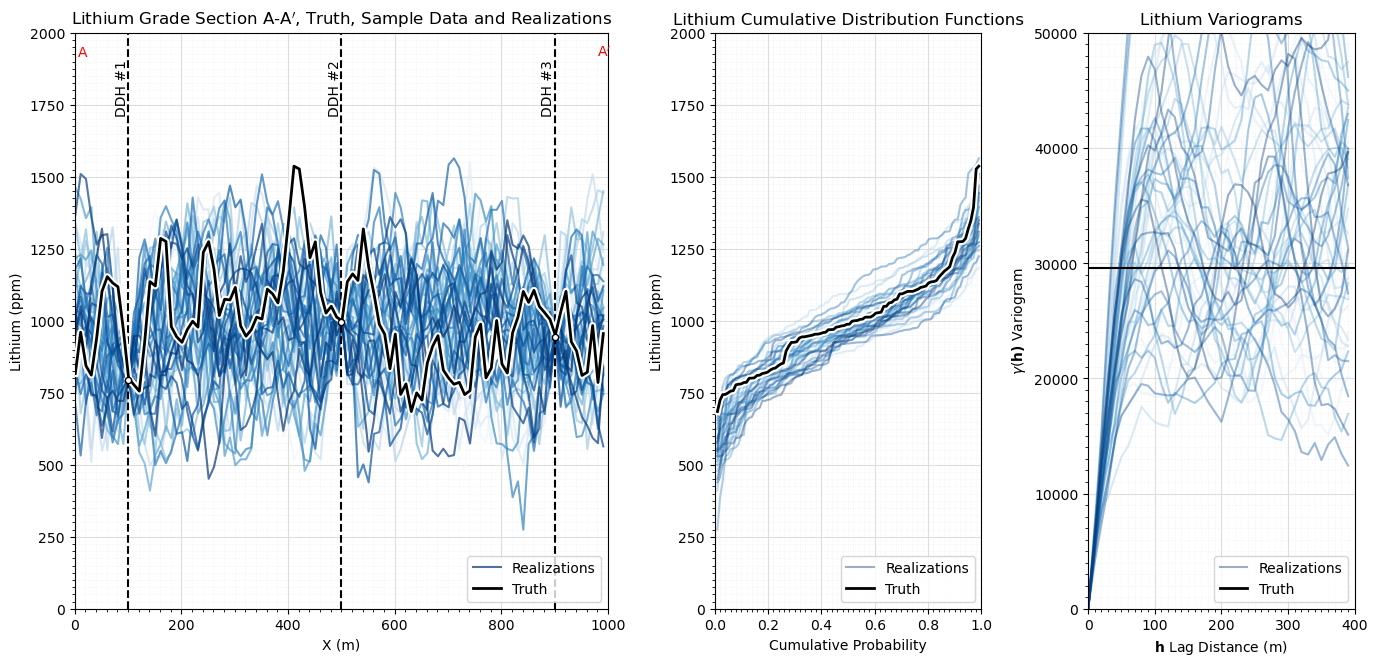

In [5]:
nreal = 50                                                    # number of realizations 

fig = plt.figure()
grid_spec = gridspec.GridSpec(ncols = 3,nrows=1,width_ratios=[2, 1, 1])

ax0 = fig.add_subplot(grid_spec[0])

with io.capture_output() as captured:
    sim = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
        twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=nreal,
        nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=83090,
        ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,
        ktype=0,colocorr=0.0,sec_map=0,vario=vario_truth).reshape((nreal,nx)) # nd_array[nreal,nx] of realizations

for i in range(0, nreal):
    if i == nreal - 1:
        ax0.plot(np.arange(1,(nx*xsiz),xsiz),sim[i],color=plt.cm.Blues(i/nreal),alpha=0.7,zorder=1,label='Realizations')
    else:
        ax0.plot(np.arange(1,(nx*xsiz),xsiz),sim[i],color=plt.cm.Blues(i/nreal),alpha=0.7,zorder=1)  
        
ax0.plot(np.arange(1,(nx*xsiz),xsiz),truth,color='black',label='Truth',lw=2,zorder=10)
ax0.plot(np.arange(1,(nx*xsiz),xsiz),truth,color='white',lw=5,zorder=5)

plt.annotate(r'DDH #1',(75,1720),rotation = 90); plt.annotate(r'DDH #2',(475,1720),rotation = 90) 
plt.annotate(r'DDH #3',(875,1720),rotation = 90) 

plt.annotate(r'A',(5,1920),color='red'); plt.annotate(r'A$^\prime$',(980,1920),color='red') 

plt.scatter(500,995,s=20,color='white',edgecolor='black',zorder=10); plt.scatter(100,795,s=20,color='white',edgecolor='black',zorder=10)
plt.scatter(900,945,s=20,color='white',edgecolor='black',zorder=10)

plt.plot([100,100],[0,2000],color='black',ls='--'); plt.plot([900,900],[0,2000],color='black',ls='--')
plt.plot([500,500],[0,2000],color='black',ls='--')
    
plt.ylim([0,2000]); plt.xlim([0,1000]) 
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8)
gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Grade Section A-A$^\prime$, Truth, Sample Data and Realizations')

plt.legend(loc='lower right')

ax1 = fig.add_subplot(grid_spec[1])                           # visualize the CDFs

for i in range(0, nreal):
    sim_sort = np.sort(sim[i])
    p = ((np.arange(len(sim[i])))+1)/(len(sim[i]) + 1)        # CDF unknown lower and upper tail assumption
    if i == nreal-1:
        plt.plot(p,sim_sort,c = plt.cm.Blues(i/nreal),alpha = 0.4,zorder=1,label='Realizations')
    else:
        plt.plot(p,sim_sort,c = plt.cm.Blues(i/nreal),alpha = 0.4,zorder=1)

truth_sort = np.sort(truth)
p = ((np.arange(len(truth)))+1)/(len(truth) + 1)              # CDF unknown lower and upper tail assumption
plt.plot(p,truth_sort,c = 'white',lw=5,zorder=5)
plt.plot(p,truth_sort,c = 'black',lw=2,zorder=10,label='Truth')

plt.ylabel('Lithium (ppm)'); plt.xlabel('Cumulative Probability'); plt.grid(); 
plt.title('Lithium Cumulative Distribution Functions')
plt.xlim([0,1]); plt.ylim([0,2000])

gca= plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8)
gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
   
plt.legend(loc='lower right')   

ax2 = fig.add_subplot(grid_spec[2])                           # visualize experimental variograms
                            
truth_series = pd.Series(truth[0]);  gamma_truth = []; num_pairs_all = []
  
for ilag in range(0,40):
    num_pairs_all.append(float(len((truth_series - truth_series.shift(ilag)).dropna())))
    gamma_truth.append(np.average(np.square((truth_series - truth_series.shift(ilag)).dropna()))*0.5) 

lithium_var = np.var(truth)
for i in range(0, nreal):                            
    sim_series = pd.Series(sim[i])
    gamma_sim = []
    for ilag in range(0,40):
        num_pairs_all.append(float(len((truth_series - truth_series.shift(ilag)).dropna()))) 
        gamma_sim.append(np.average(np.square((sim_series - sim_series.shift(ilag)).dropna()))*0.5)  
    if i == nreal-1:
        scatter = ax2.plot(np.arange(0,40)*xsiz,gamma_sim,color=plt.cm.Blues(i/nreal),alpha=0.4,label='Realizations')
    else:
        scatter = ax2.plot(np.arange(0,40)*xsiz,gamma_sim,color=plt.cm.Blues(i/nreal),alpha=0.4)
    
plt.plot(np.arange(0,40)*xsiz,gamma_truth,c = 'white',lw=5,zorder=5)
plt.plot(np.arange(0,40)*xsiz,gamma_truth,c = 'black',lw=2,zorder=10,label='Truth')    

plt.plot([0,400],[lithium_var,lithium_var],color='black')
plt.xlim([0,400]); plt.ylim([0,50000]); plt.title('Lithium Variograms')
plt.xlabel(r'$\bf{h}$ Lag Distance (m)'); plt.ylabel(r'$\gamma(\bf{h})$ Variogram')
    
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8)
gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)

plt.legend(loc='lower right')
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.3, hspace=0.2); plt.show()

#### Short Range Continuity Case

Let's repeat the above for a short range continuity case.

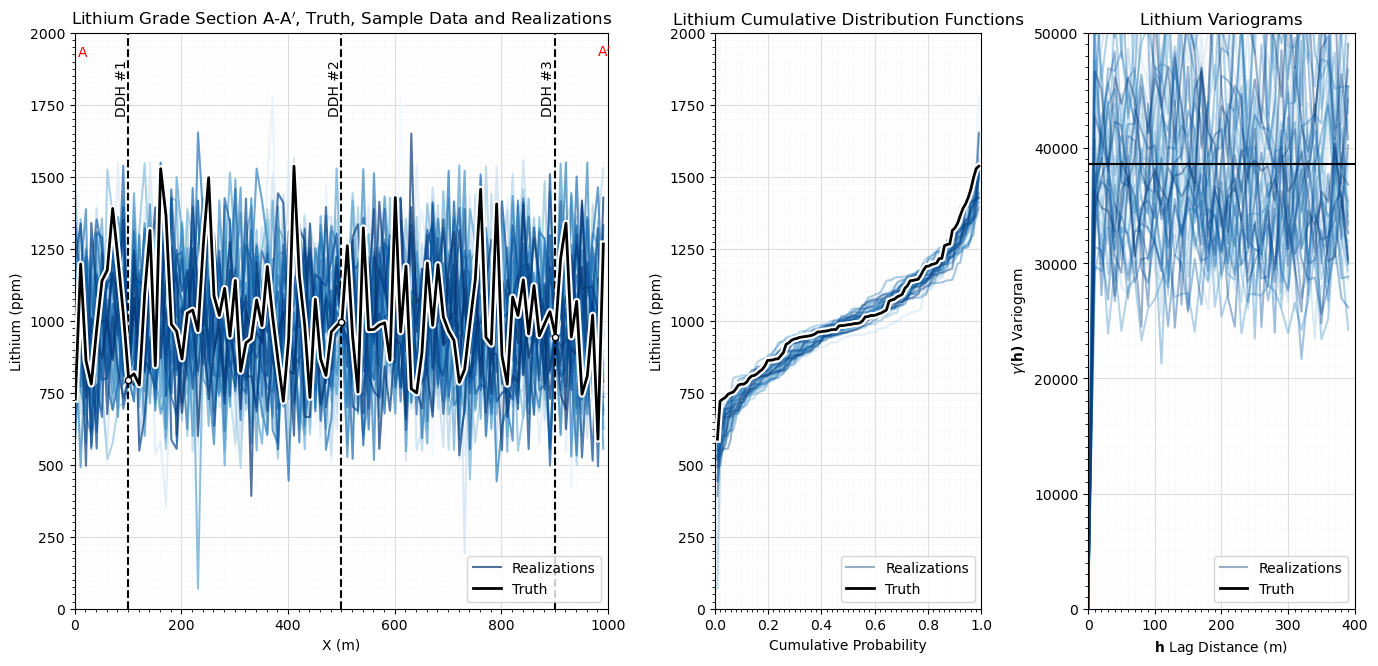

In [6]:
nreal = 50; vrange = 10                                       # number of realizations and variogram range

vario1 = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=90.0,hmaj1=vrange,hmin1=5)

with io.capture_output() as captured:
    truth = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
        twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=1,
        nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=72067,
        ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,
        ktype=0,colocorr=0.0,sec_map=0,vario=vario1)[0][0]

fig = plt.figure()
grid_spec = gridspec.GridSpec(ncols = 3,nrows=1,width_ratios=[2, 1, 1])

ax0 = fig.add_subplot(grid_spec[0])                           # visualize the truth and realizations

with io.capture_output() as captured:
    sim = geostats.sgsim(df,'X','Y','Lithium',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=2000.0,ltail=1,ltpar=0.0,utail=1,utpar=2000,nsim=nreal,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=83090+i,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,
            ktype=0,colocorr=0.0,sec_map=0,vario=vario1).reshape((nreal,nx))

for i in range(0, nreal):
    if i == nreal - 1:
        ax0.plot(np.arange(1,(nx*xsiz),xsiz),sim[i],color=plt.cm.Blues(i/nreal),alpha=0.7,zorder=1,label='Realizations')
    else:
        ax0.plot(np.arange(1,(nx*xsiz),xsiz),sim[i],color=plt.cm.Blues(i/nreal),alpha=0.7,zorder=1)  
        
ax0.plot(np.arange(1,(nx*xsiz),xsiz),truth,color='black',label='Truth',lw=2,zorder=10)
ax0.plot(np.arange(1,(nx*xsiz),xsiz),truth,color='white',lw=5,zorder=5)

plt.annotate(r'DDH #1',(75,1720),rotation = 90); plt.annotate(r'DDH #2',(475,1720),rotation = 90) 
plt.annotate(r'DDH #3',(875,1720),rotation = 90) 

plt.annotate(r'A',(5,1920),color='red'); plt.annotate(r'A$^\prime$',(980,1920),color='red') 

plt.scatter(500,995,s=20,color='white',edgecolor='black',zorder=10); plt.scatter(100,795,s=20,color='white',edgecolor='black',zorder=10)
plt.scatter(900,945,s=20,color='white',edgecolor='black',zorder=10)

plt.plot([100,100],[0,2000],color='black',ls='--'); plt.plot([900,900],[0,2000],color='black',ls='--')
plt.plot([500,500],[0,2000],color='black',ls='--')
    
plt.ylim([0,2000]); plt.xlim([0,1000]) 
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8)
gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
plt.xlabel('X (m)'); plt.ylabel('Lithium (ppm)'); plt.title('Lithium Grade Section A-A$^\prime$, Truth, Sample Data and Realizations')

plt.legend(loc='lower right')

ax1 = fig.add_subplot(grid_spec[1])                           # visualize the CDFs

for i in range(0, nreal):
    sim_sort = np.sort(sim[i])
    p = ((np.arange(len(sim[i])))+1)/(len(sim[i]) + 1)        # CDF unknown lower and upper tail assumption
    if i == nreal-1:
        plt.plot(p,sim_sort,c = plt.cm.Blues(i/nreal),alpha = 0.4,zorder=1,label='Realizations')
    else:
        plt.plot(p,sim_sort,c = plt.cm.Blues(i/nreal),alpha = 0.4,zorder=1)

truth_sort = np.sort(truth)
p = ((np.arange(len(truth)))+1)/(len(truth) + 1)              # CDF unknown lower and upper tail assumption
plt.plot(p,truth_sort,c = 'white',lw=5,zorder=5)
plt.plot(p,truth_sort,c = 'black',lw=2,zorder=10,label='Truth')

plt.ylabel('Lithium (ppm)'); plt.xlabel('Cumulative Probability'); plt.grid(); 
plt.title('Lithium Cumulative Distribution Functions')
plt.xlim([0,1]); plt.ylim([0,2000])

gca= plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8)
gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)
   
plt.legend(loc='lower right')   

ax2 = fig.add_subplot(grid_spec[2])                           # visualize experimental variograms
                            
truth_series = pd.Series(truth[0]);  gamma_truth = []; num_pairs_all = []
  
for ilag in range(0,40):
    num_pairs_all.append(float(len((truth_series - truth_series.shift(ilag)).dropna())))
    gamma_truth.append(np.average(np.square((truth_series - truth_series.shift(ilag)).dropna()))*0.5) 
  
lithium_var = np.var(truth)
for i in range(0, nreal):                            
    sim_series = pd.Series(sim[i])
    gamma_sim = []
    for ilag in range(0,40):
        num_pairs_all.append(float(len((truth_series - truth_series.shift(ilag)).dropna()))) 
        gamma_sim.append(np.average(np.square((sim_series - sim_series.shift(ilag)).dropna()))*0.5)  
    

    if i == nreal-1:
        scatter = ax2.plot(np.arange(0,40)*xsiz,gamma_sim,color=plt.cm.Blues(i/nreal),alpha=0.4,label='Realizations')
    else:
        scatter = ax2.plot(np.arange(0,40)*xsiz,gamma_sim,color=plt.cm.Blues(i/nreal),alpha=0.4)
    
plt.plot(np.arange(0,40)*xsiz,gamma_truth,c = 'white',lw=5,zorder=5)
plt.plot(np.arange(0,40)*xsiz,gamma_truth,c = 'black',lw=2,zorder=10,label='Truth')    

plt.plot([0,400],[lithium_var,lithium_var],color='black')
plt.xlim([0,400]); plt.ylim([0,50000]); plt.title('Lithium Variograms')
plt.xlabel(r'$\bf{h}$ Lag Distance (m)'); plt.ylabel(r'$\gamma(\bf{h})$ Variogram')
    
gca = plt.gca()
gca.xaxis.set_minor_locator(AutoMinorLocator(10))
gca.yaxis.set_minor_locator(AutoMinorLocator(10))
gca.grid(which='major', color='#DDDDDD', linewidth=0.8)
gca.grid(which='minor',color='#EEEEEE', linestyle=':', linewidth=0.5)

plt.legend(loc='lower right')
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.3, hspace=0.2); plt.show()

#### Comments

This was a basic demonstration ergodic fluctuations for a simulated lithium grade model. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### The Author:

Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
  